In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

1. Exploratory Data Analysis

In [5]:
# Load and inspect data
df = pd.read_csv('../data/trading_summary.csv', parse_dates=['Date'], index_col='Date')
print(df.head())
print("\nData description:")
print(df.describe())

            Unnamed: 0  Adj Close     Close      High       Low      Open  \
Date                                                                        
1980-03-17           0   2.296798  3.291227  3.344743  3.291227  0.000000   
1980-03-18           1   2.306134  3.304606  3.358122  3.304606  0.000000   
1980-03-19           2   2.306134  3.304606  3.304606  3.304606  3.304606   
1980-03-20           3   2.306134  3.304606  3.358122  3.304606  0.000000   
1980-03-21           4   2.362154  3.384880  3.438396  3.384880  0.000000   

             Volume  
Date                 
1980-03-17  41109.0  
1980-03-18   9343.0  
1980-03-19      0.0  
1980-03-20  10277.0  
1980-03-21   8409.0  

Data description:
         Unnamed: 0     Adj Close         Close          High           Low  \
count  11291.000000  11198.000000  11174.000000  11196.000000  11164.000000   
mean    5645.000000     63.609130     72.026945     72.503100     71.665079   
std     3259.575279     52.266247     51.259828   

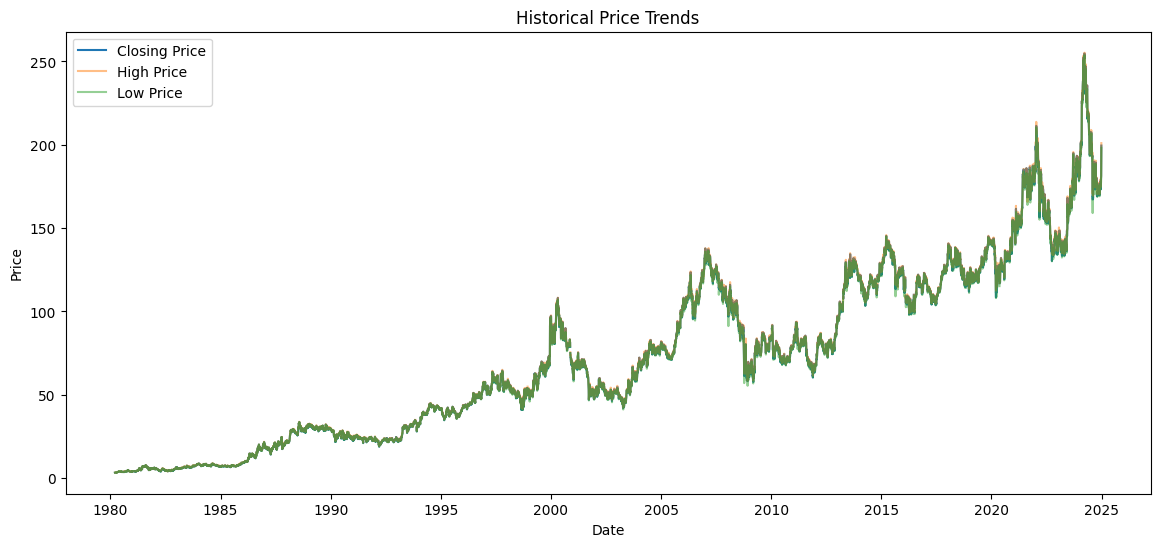

In [6]:
# Plot price trends
plt.figure(figsize=(14, 6))
plt.plot(df['Close'], label='Closing Price')
plt.plot(df['High'], label='High Price', alpha=0.5)
plt.plot(df['Low'], label='Low Price', alpha=0.5)
plt.title('Historical Price Trends')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

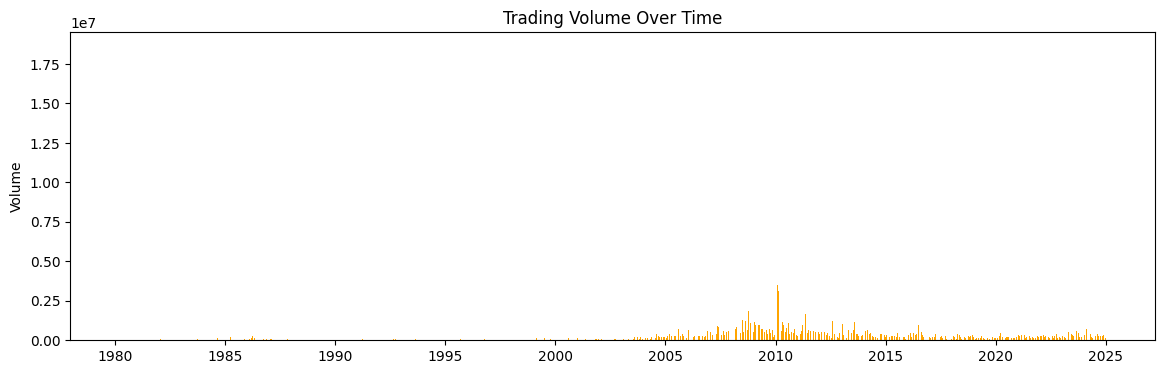

In [7]:
# Volume analysis
plt.figure(figsize=(14, 4))
plt.bar(df.index, df['Volume'], color='orange')
plt.title('Trading Volume Over Time')
plt.ylabel('Volume')
plt.show()

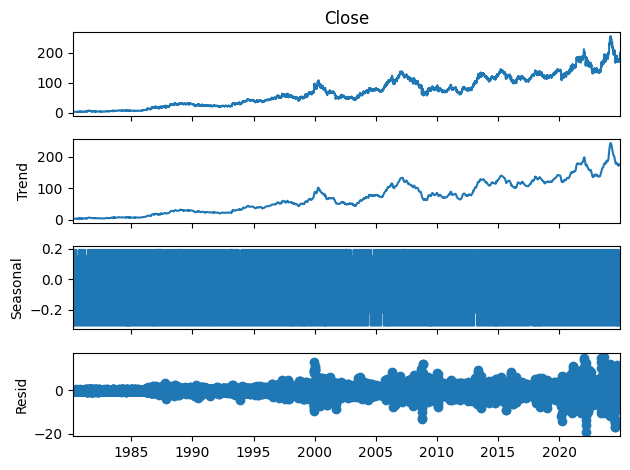

In [8]:
# Seasonal decomposition
result = seasonal_decompose(df['Close'].ffill(), period=30, model='additive')
result.plot()
plt.tight_layout()
plt.show()

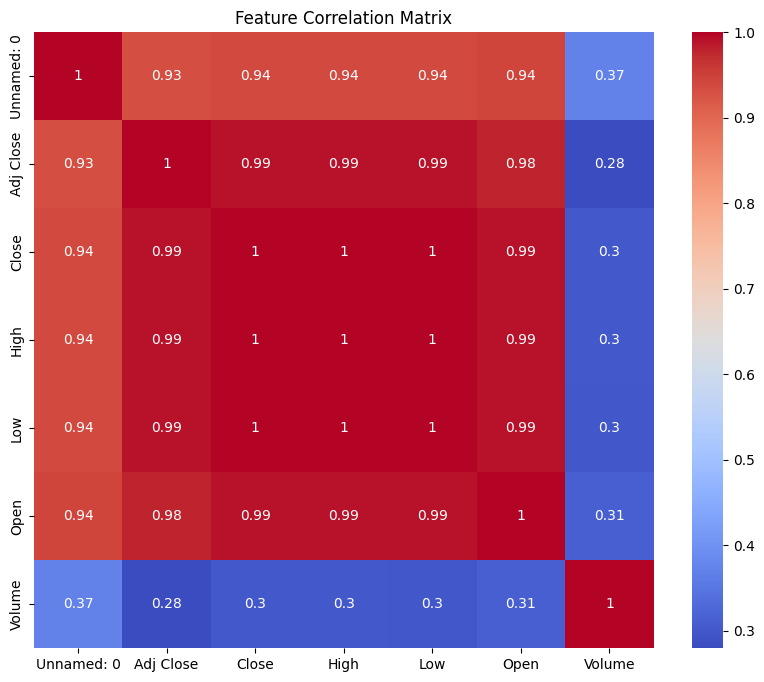

In [9]:
# Correlation analysis
corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

2. Feature Engineering & Preprocessing

In [10]:
# %%
# Create technical indicators
df['5D_MA'] = df['Close'].rolling(window=5).mean()
df['10D_MA'] = df['Close'].rolling(window=10).mean()
df['Price_Change'] = df['Close'].pct_change()
df['Volatility'] = df['Close'].rolling(window=5).std()

# Create lag features
for lag in [1, 3, 5, 7]:
    df[f'Lag_{lag}'] = df['Close'].shift(lag)

# Create target variable (5-day future price)
df['Target'] = df['Close'].shift(-5)

# Drop missing values
df.dropna(inplace=True)

# Split data
features = ['Close', '5D_MA', '10D_MA', 'Price_Change', 'Volatility', 
           'Lag_1', 'Lag_3', 'Lag_5', 'Volume']
target = 'Target'

split_idx = int(len(df) * 0.8)
train = df.iloc[:split_idx]
test = df.iloc[split_idx:]

# Scale features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[features])
test_scaled = scaler.transform(test[features])

C:\Users\dasun\AppData\Local\Temp\ipykernel_2096\3416665923.py:5: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Price_Change'] = df['Close'].pct_change()


3. Model Development

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [14]:
# Create sequences
def create_sequences(data, n_steps=30):
    X, y = [], []
    for i in range(len(data)-n_steps-5):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps:i+n_steps+5, 0])  # First column is Close price
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_scaled)
X_test, y_test = create_sequences(test_scaled)

In [15]:
# Build LSTM model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(5)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

C:\Users\dasun\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
# Train model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)]
)



Epoch 1/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - loss: 0.0186 - mae: 0.0751 - val_loss: 0.0014 - val_mae: 0.0282
Epoch 2/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0022 - mae: 0.0294 - val_loss: 0.0032 - val_mae: 0.0481
Epoch 3/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0015 - mae: 0.0250 - val_loss: 0.0012 - val_mae: 0.0261
Epoch 4/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0012 - mae: 0.0230 - val_loss: 0.0013 - val_mae: 0.0276
Epoch 5/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0011 - mae: 0.0219 - val_loss: 9.5555e-04 - val_mae: 0.0234
Epoch 6/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 0.0011 - mae: 0.0223 - val_loss: 9.7479e-04 - val_mae: 0.0235
Epoch 7/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - loss: 9.7709e-04 - mae: 0.0212 - val_loss: 7.8561e-04 - val_mae: 0.0206
Epoch 8/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 7.8555e-04 - mae: 0.0187 - val_loss: 0.0015 - val_mae: 0.0301
Epoch 9/100
190/190 

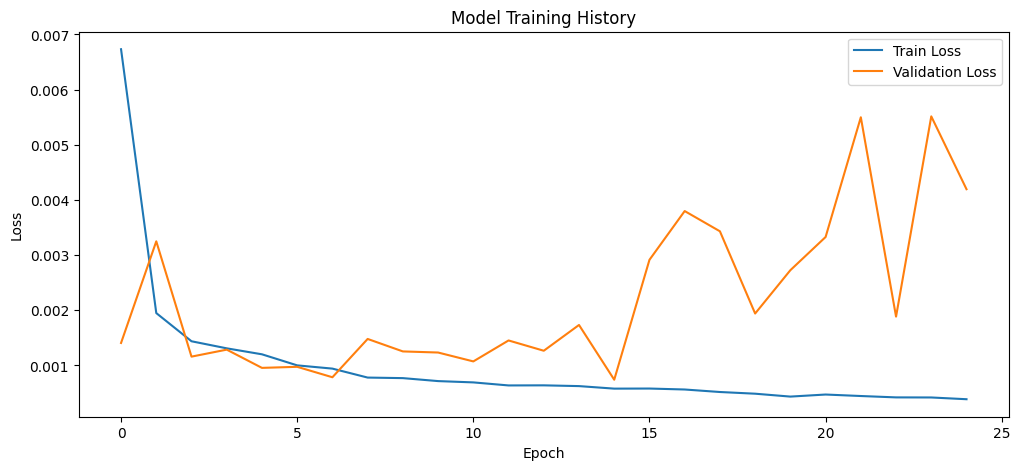

In [18]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Save model
model.save('../models/lstm_model.h5')

4. Evaluation & Predictions

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
RMSE: 11.85
MAE: 8.22


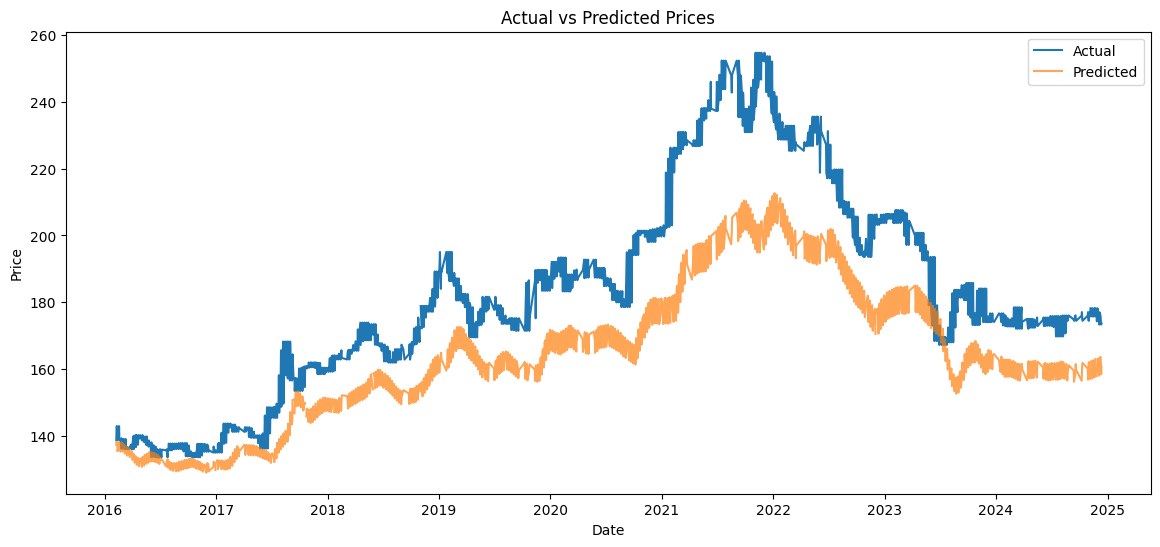

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Generate predictions
y_pred = model.predict(X_test)

# Inverse scaling
scaler_target = MinMaxScaler()
scaler_target.fit(train[['Close']])

y_test_inv = scaler_target.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler_target.inverse_transform(y_pred.reshape(-1, 1))

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')

# Save predictions
pred_dates = test.index[30+5:-5]
# results = pd.DataFrame({
#     'Date': pred_dates,
#     'Actual': y_test_inv.flatten(),
#     'Predicted': y_pred_inv.flatten()
# })
y_test_trimmed = y_test_inv[-len(pred_dates):].flatten()
y_pred_trimmed = y_pred_inv[-len(pred_dates):].flatten()

results = pd.DataFrame({
    'Date': pred_dates,
    'Actual': y_test_trimmed,
    'Predicted': y_pred_trimmed
})


results.to_csv('../data/predictions.csv', index=False)

# Plot predictions
plt.figure(figsize=(14, 6))
plt.plot(results['Date'], results['Actual'], label='Actual')
plt.plot(results['Date'], results['Predicted'], label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()